This code requires an install of [GALFITM](https://www.nottingham.ac.uk/astronomy/megamorph/) to be present. Please edit the cell below to point to your version.

In [1]:
GALFITM_EXECUTABLE = 'galfitm-1.2.1-osx'

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
from IPython.display import display
import matplotlib.pyplot as plt
import json
import subprocess
from copy import deepcopy
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
import sdssCutoutGrab as scg
import lib.galaxy_utilities as gu
import lib.python_model_renderer.render_galaxy as rg
import lib.python_model_renderer.parse_annotation as pa
import model_to_galfit as m2g
from model_fitting import Model, ModelFitter

In [4]:
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

In [5]:
plt.style.use('seaborn-dark')

In [6]:
to_iter = pd.read_csv('lib/subject-id-list.csv').values[:, 0]

In [7]:
with open('lib/best-classifications.json') as f:
    best_cls = json.load(f)

In [8]:
sd = pd.read_csv('lib/Kruk2018_Table2_Table3.csv')
coords = SkyCoord(ra=sd['ra']*u.degree, dec=sd['dec']*u.degree)
s_keys = [
  'ra', 'dec', 'Fit_components',
  'r_disc', 're_disc', 'ba_disc',
  'r_bulge', 're_bulge', 'ba_bulge', 'n_bulge',
  'r_bar', 're_bar', 'ba_bar', 'n_bar',
]

In [9]:
def isin_sandor(subject_id):
    gal, angle = gu.get_galaxy_and_angle(subject_id)
    sep = coords.separation(SkyCoord(ra=gal['RA']*u.degree, dec=gal['DEC']*u.degree))
    idxmin_sep = np.argmin(sep)
    if not sep[idxmin_sep] < 1 * u.arcsec:
        return False
    return True
sandor_sids = list(filter(isin_sandor, to_iter))

In [10]:
subject_id = sandor_sids[3]

In [11]:
gal, angle = gu.get_galaxy_and_angle(subject_id)
psf = gu.get_psf(subject_id)
diff_data = gu.get_image_data(subject_id)
galaxy_data = np.array(diff_data['imageData'])[::-1]
pixel_mask = 1 - np.array(diff_data['mask'])[::-1]
size_diff = diff_data['width'] / diff_data['imageWidth']
gal = gal.iloc[0]
frame = scg.queryFromRaDec(gal['RA'], gal['DEC'])[0]

In [12]:
f_o_loc = m2g.get_original_fits(frame)
f_o = m2g.fits.open(f_o_loc)
f_o.info()

Filename: /Users/tlingard/PhD/galaxy-builder/data-aggregation/model-scoring/lib/fitsImages/5071/5/frame-r-005071-5-0132.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      96   (2048, 1489)   float32   
  1                1 ImageHDU         6   (2048,)   float32   
  2                1 BinTableHDU     27   1R x 3C   [49152E, 2048E, 1489E]   
  3                1 BinTableHDU     79   1R x 31C   [J, 3A, J, A, D, D, 2J, J, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, E, E]   


In [13]:
dd = gu.get_image_data(subject_id)
coord = np.array((gal['RA'], gal['DEC']))
cutout_size = 4 * np.tile(gal['PETRO_THETA'], 2)

im, s = scg.cutFits(f_o, *coord, size=cutout_size, sigma=True)

In [14]:
cls = gu.classifications.query('classification_id == {}'.format(best_cls.get(str(subject_id)))).iloc[0]

model = pa.parse_annotation(json.loads(cls['annotations']), size_diff=size_diff)
display(model['disk'])
display(model['bulge'])
display(model['bar'])

{'mu': array([64.3187561 , 63.45000458]),
 'roll': 1.2917244496901605,
 'rEff': 50.16273186497659,
 'axRatio': 0.7546253461192564,
 'i0': 0.04,
 'c': 2,
 'n': 1}

{'mu': array([64.60359192, 63.60425568]),
 'roll': 1.3156132837691834,
 'rEff': 3.069963617551184,
 'axRatio': 0.7256422023474632,
 'i0': 1.97,
 'c': 2,
 'n': 3.11}

{'mu': array([63.79637718, 63.80606651]),
 'roll': 0.5516554361110337,
 'rEff': 5.126201591851494,
 'axRatio': 0.250429646114015,
 'i0': 0.21,
 'c': 2.02,
 'n': 0.35}

In [15]:
no_spiral_model = deepcopy(model)
no_spiral_model['spiral'] = []

In [16]:
mf_nosp = ModelFitter(no_spiral_model, galaxy_data, psf, pixel_mask)
%time new_nosp_model, res = mf_nosp.fit(options={'maxiter': 50})

CPU times: user 1min, sys: 1.77 s, total: 1min 2s
Wall time: 1min 6s


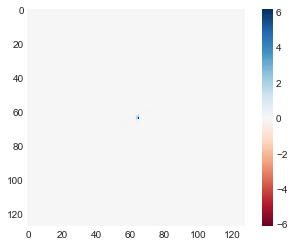

In [17]:
# plt.imshow(rg.post_process(md_nosp_fit.render(new_nosp_model), psf), cmap='gray')
a = rg.calculate_model(no_spiral_model, diff_data['width'])
b = rg.calculate_model(new_nosp_model, diff_data['width'])

plt.imshow(a - b, cmap='RdBu', vmin=-np.abs(a - b).max(), vmax=np.abs(a - b).max())
plt.colorbar()
# plt.imshow(rg.compare_to_galaxy(md_nosp_fit.render(new_nosp_model), psf, galaxy_data, pixel_mask))
# plt.colorbar()

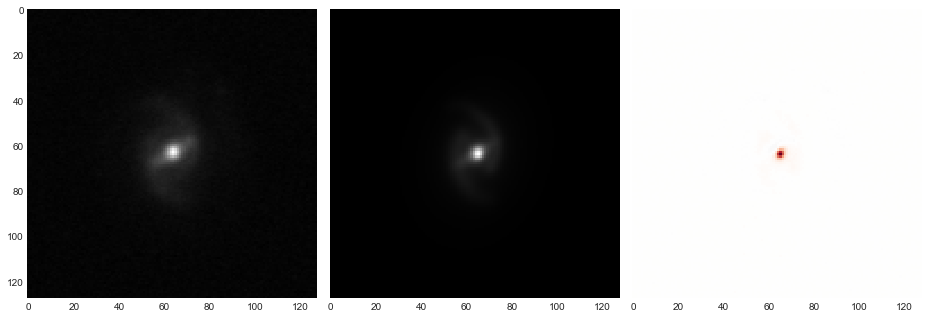

In [18]:
rendered_model = rg.convolve2d(
    rg.calculate_model(model, diff_data['width']),
    psf, mode='same', boundary='symm'
)
residual = 0.8 * galaxy_data - rendered_model

fig, ax = plt.subplots(ncols=3, figsize=(13, 5), sharey=True)
plt.sca(ax[0])
plt.imshow(rg.asinh_stretch(galaxy_data), cmap='gray')
plt.sca(ax[1])
plt.imshow(rg.asinh_stretch(rendered_model/0.8), cmap='gray')
plt.sca(ax[2])
plt.imshow(residual, vmin=-np.abs(residual).max(), vmax=np.abs(residual).max(), cmap='RdGy')
plt.tight_layout();

In [19]:
file_locations = m2g.make_galfit_feedme(subject_id, cls, output_dir='galfit_files')

🤖 [sdssCutoutGrab Info] writing to galfit_files/20902053/135762246/PSF.fits


In [20]:
cmd = '{} {}'.format(GALFITM_EXECUTABLE, file_locations['feedme'])
print('Running command', cmd)

Running command galfitm-1.2.1-osx galfit_files/20902053/135762246/galfit.feedme


In [21]:
output_fits = fits.open(file_locations['output'])
output_fits.info()

FileNotFoundError: [Errno 2] No such file or directory: 'galfit_files/20902053/135762246/imgblock.fits'

In [22]:
output_model = np.array(output_fits['MODEL'].data, dtype=float).T[::-1, ::-1]
galfit_residual = np.array(
    output_fits['RESIDUAL'].data, dtype=float
).T[::-1, ::-1] * (1 - np.array(diff_data['mask'])[::-1])

NameError: name 'output_fits' is not defined

NameError: name 'output_model' is not defined

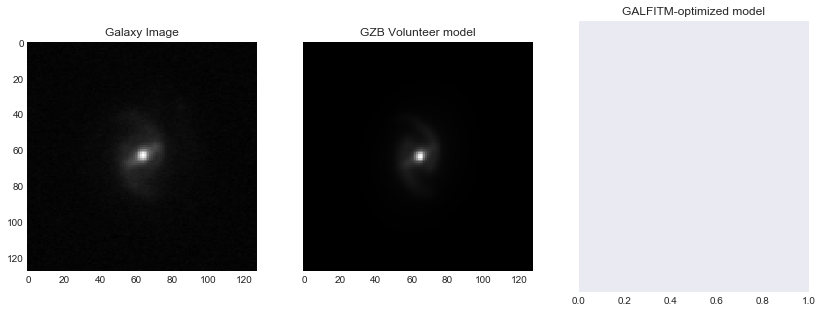

In [23]:
fig, ax = plt.subplots(ncols=3, figsize=(14, 5), sharey=True)
plt.sca(ax[0])
plt.title('Galaxy Image')
plt.imshow(rg.asinh_stretch(galaxy_data), cmap='gray')
plt.sca(ax[1])
plt.title('GZB Volunteer model')
plt.imshow(rg.asinh_stretch(rendered_model/0.8), cmap='gray')
plt.sca(ax[2])
plt.title('GALFITM-optimized model')
plt.imshow(rg.asinh_stretch(output_model), cmap='gray')
plt.tight_layout();

NameError: name 'galfit_residual' is not defined

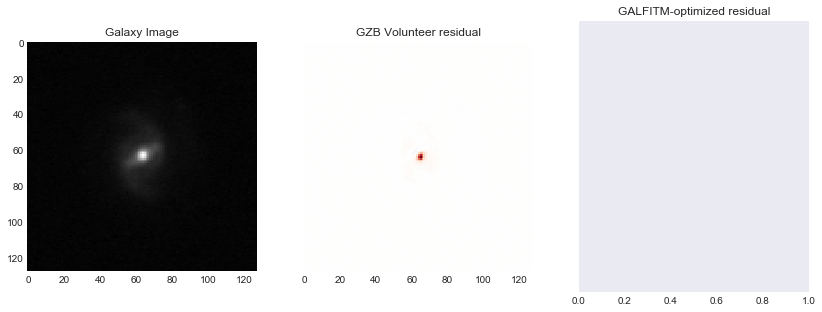

In [24]:
l = np.abs(residual).max()
fig, ax = plt.subplots(ncols=3, figsize=(14, 5), sharey=True)
plt.sca(ax[0])
plt.title('Galaxy Image')
plt.imshow(rg.asinh_stretch(galaxy_data), cmap='gray')
plt.sca(ax[1])
plt.title('GZB Volunteer residual')
plt.imshow(residual, cmap='RdGy', vmin=-l, vmax=l)
plt.sca(ax[2])
plt.title('GALFITM-optimized residual')
plt.imshow(galfit_residual, cmap='RdGy', vmin=-l, vmax=l)
plt.tight_layout();

In [25]:
input_fits = fits.open(file_locations['image'])
mask_fits = fits.open(file_locations['mask'])

In [26]:
output_fits.info()

NameError: name 'output_fits' is not defined